In [16]:
import os
import logging
import multiprocessing as mp

import hydra
from omegaconf import OmegaConf, DictConfig


# JAX & Equinox
import jax
import jax.random as jr
import equinox as eqx
import wandb
import jax.profiler
import jax.numpy as jnp
import numpy as np

# Foundational SSM core imports
from foundational_ssm.models import SSMFoundationalDecoder
from foundational_ssm.utils.pretrain_utils import mse_loss_foundational
from foundational_ssm.utils.wandb_utils_jax import (
    save_checkpoint_wandb,
    add_alias_to_checkpoint,
)
from foundational_ssm.constants import DATA_ROOT
from foundational_ssm.loaders import get_brainset_train_val_loaders
from foundational_ssm.utils.pretrain_utils import (
    create_optimizer_and_state,
    train_one_epoch,
    validate_one_epoch,
    load_training_state
)

%load_ext autoreload
%autoreload 2


cfg = OmegaConf.load('../configs/pretrain_notebook.yaml')
mp.set_start_method("spawn", force=True)

loss_fn = mse_loss_foundational

cfg, model, state, opt, opt_state, start_epoch, lr_scheduler, current_step, best_r2_score \
    = load_training_state(cfg, model_cls=SSMFoundationalDecoder, wandb_resume_run_id="t7lw3ovo")
    
_, train_loader, _, val_loader = get_brainset_train_val_loaders(
        cfg.train_loader,
        cfg.val_loader,
        cfg.dataset_cfg,
        data_root='../' + DATA_ROOT
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'model_cfg': 'configs/model/l2.yaml', 'dataset_cfg': 'configs/dataset/same_animal_same_year.yaml', 'rng_seed': 42, 'training': {'log_val_every': 50, 'checkpoint_every': 50, 'epochs': 1001}, 'skip_timesteps': 56, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'train_loader': {'sampling_rate': 200, 'dataloader_args': {'batch_size': 128, 'num_workers': 12, 'persistent_workers': True}, 'sampler': 'RandomFixedWindowSampler', 'dataset_args': {'split': 'train', 'keep_files_open': False, 'lazy': True}, 'sampler_args': {'drop_short': True, 'window_length': 3.279}}, 'val_loader': {'sampling_rate': 200, 'dataloader_args': {'batch_size': 128, 'num_workers': 0, 'persistent_workers': False}, 'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': True, 'window_length': 3.279}}}
{'model_cfg': 'configs/model/l

FileNotFoundError: [Errno 2] No such file or directory: '/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/notebooks/configs/model/l2.yaml'

In [33]:
def compute_trial_predictions_r2(val_loader, model, state):
    all_preds = []
    all_targets = []
    all_dataset_group_idxs = []
    # model = eqx.nn.inference_mode(model)
    for batch in val_loader:
        batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
        dataset_group_idxs = batch["dataset_group_idx"]
        inputs = batch["neural_input"]
        targets = batch["behavior_input"]
        mask = batch["mask"]
        mask = mask[..., None]
        preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0))

        all_preds.append(jnp.where(mask, preds, 0))
        all_targets.append(jnp.where(mask, targets, 0))
        all_dataset_group_idxs.append(dataset_group_idxs)
        
        
    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)

    ss_res = jnp.sum((all_targets - all_preds) ** 2, axis=1)
    ss_tot = jnp.sum((all_targets - jnp.mean(all_targets, axis=1, keepdims=True)) ** 2, axis=1)
    r2_per_dim = 1 - ss_res / (ss_tot + 1e-8)  # Add epsilon for stability

    all_r2 = jnp.mean(r2_per_dim, axis=1)

    return all_preds, all_targets, all_dataset_group_idxs, all_r2


In [ ]:
from foundational_ssm.utils.wandb_utils_jax import load_checkpoint_wandb
    
    
artifact_full_name = "melinajingting-ucl/foundational_ssm_pretrain/l2_same_animal_same_year_checkpoint:v1175"
model_cfg = OmegaConf.load(cfg.model_cfg)
model_cls = SSMFoundationalDecoder
model = model_cls(
        **model_cfg.model
    )
state = eqx.nn.State(model)
opt_state = create_optimizer_and_state(model, model_cfg.optimizer)
model, state, opt_state, meta = load_checkpoint_wandb(model, state, opt_state, artifact_full_name)

wandb:   3 of 3 files downloaded.  


In [34]:
all_preds, all_targets, all_dataset_group_idxs, all_r2 = compute_trial_predictions_r2(val_loader, model, state)

/tmp/ipykernel_622082/879272846.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


<Axes: title={'center': 'os_i_rt'}>

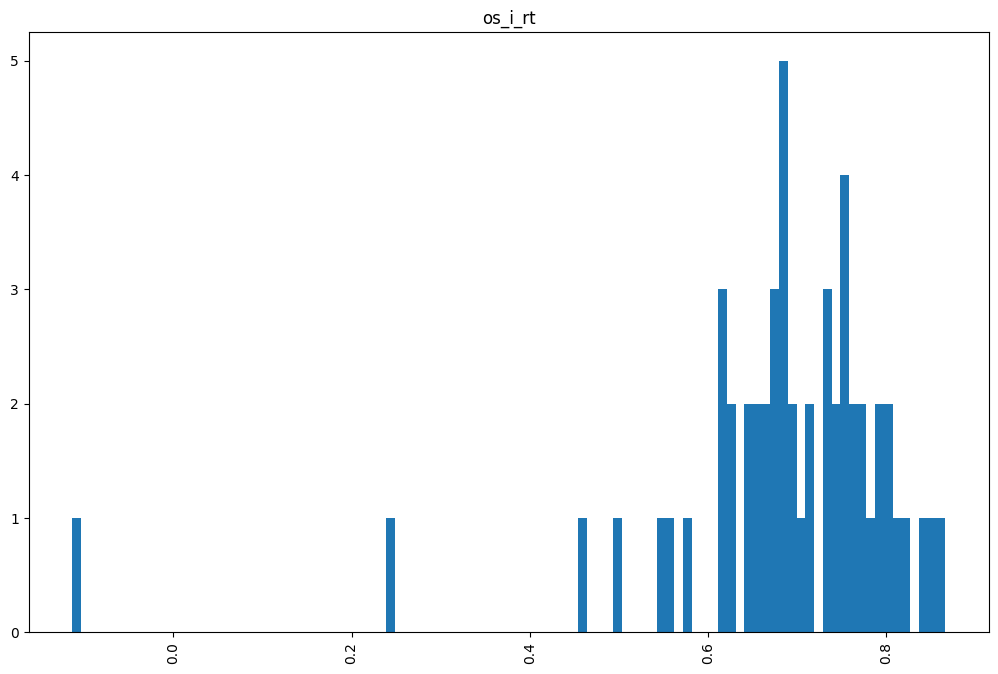

In [30]:
import pandas as pd
from foundational_ssm.constants import DATASET_IDX_TO_GROUP_SHORT
r2_df = pd.DataFrame({'dataset_group_idx': all_dataset_group_idxs, 'r2': all_r2, 'idx': np.arange(len(all_r2))})
r2_df['dataset_group'] = r2_df['dataset_group_idx'].map(DATASET_IDX_TO_GROUP_SHORT)

#get rank by desceding r2 per group 
r2_df.hist(column='r2', by='dataset_group', figsize=(12, 8), bins=100)

In [35]:
# format as 2 d.p. not scientific notation
r2_df['r2_min_0'] = r2_df['r2'].apply(lambda x: 0 if x < 0 else x)
r2_df.groupby('dataset_group').agg({'r2_min_0': ['mean', 'std', 'count']}).reset_index().rename(columns={'mean': 'mean_r2', 'std': 'std_r2', 'count': 'count_r2'}).applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

/tmp/ipykernel_622082/2739570042.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r2_df.groupby('dataset_group').agg({'r2_min_0': ['mean', 'std', 'count']}).reset_index().rename(columns={'mean': 'mean_r2', 'std': 'std_r2', 'count': 'count_r2'}).applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)


dataset_group r2_min_0                
                 mean_r2 std_r2 count_r2
0       os_i_rt     0.68   0.14       54

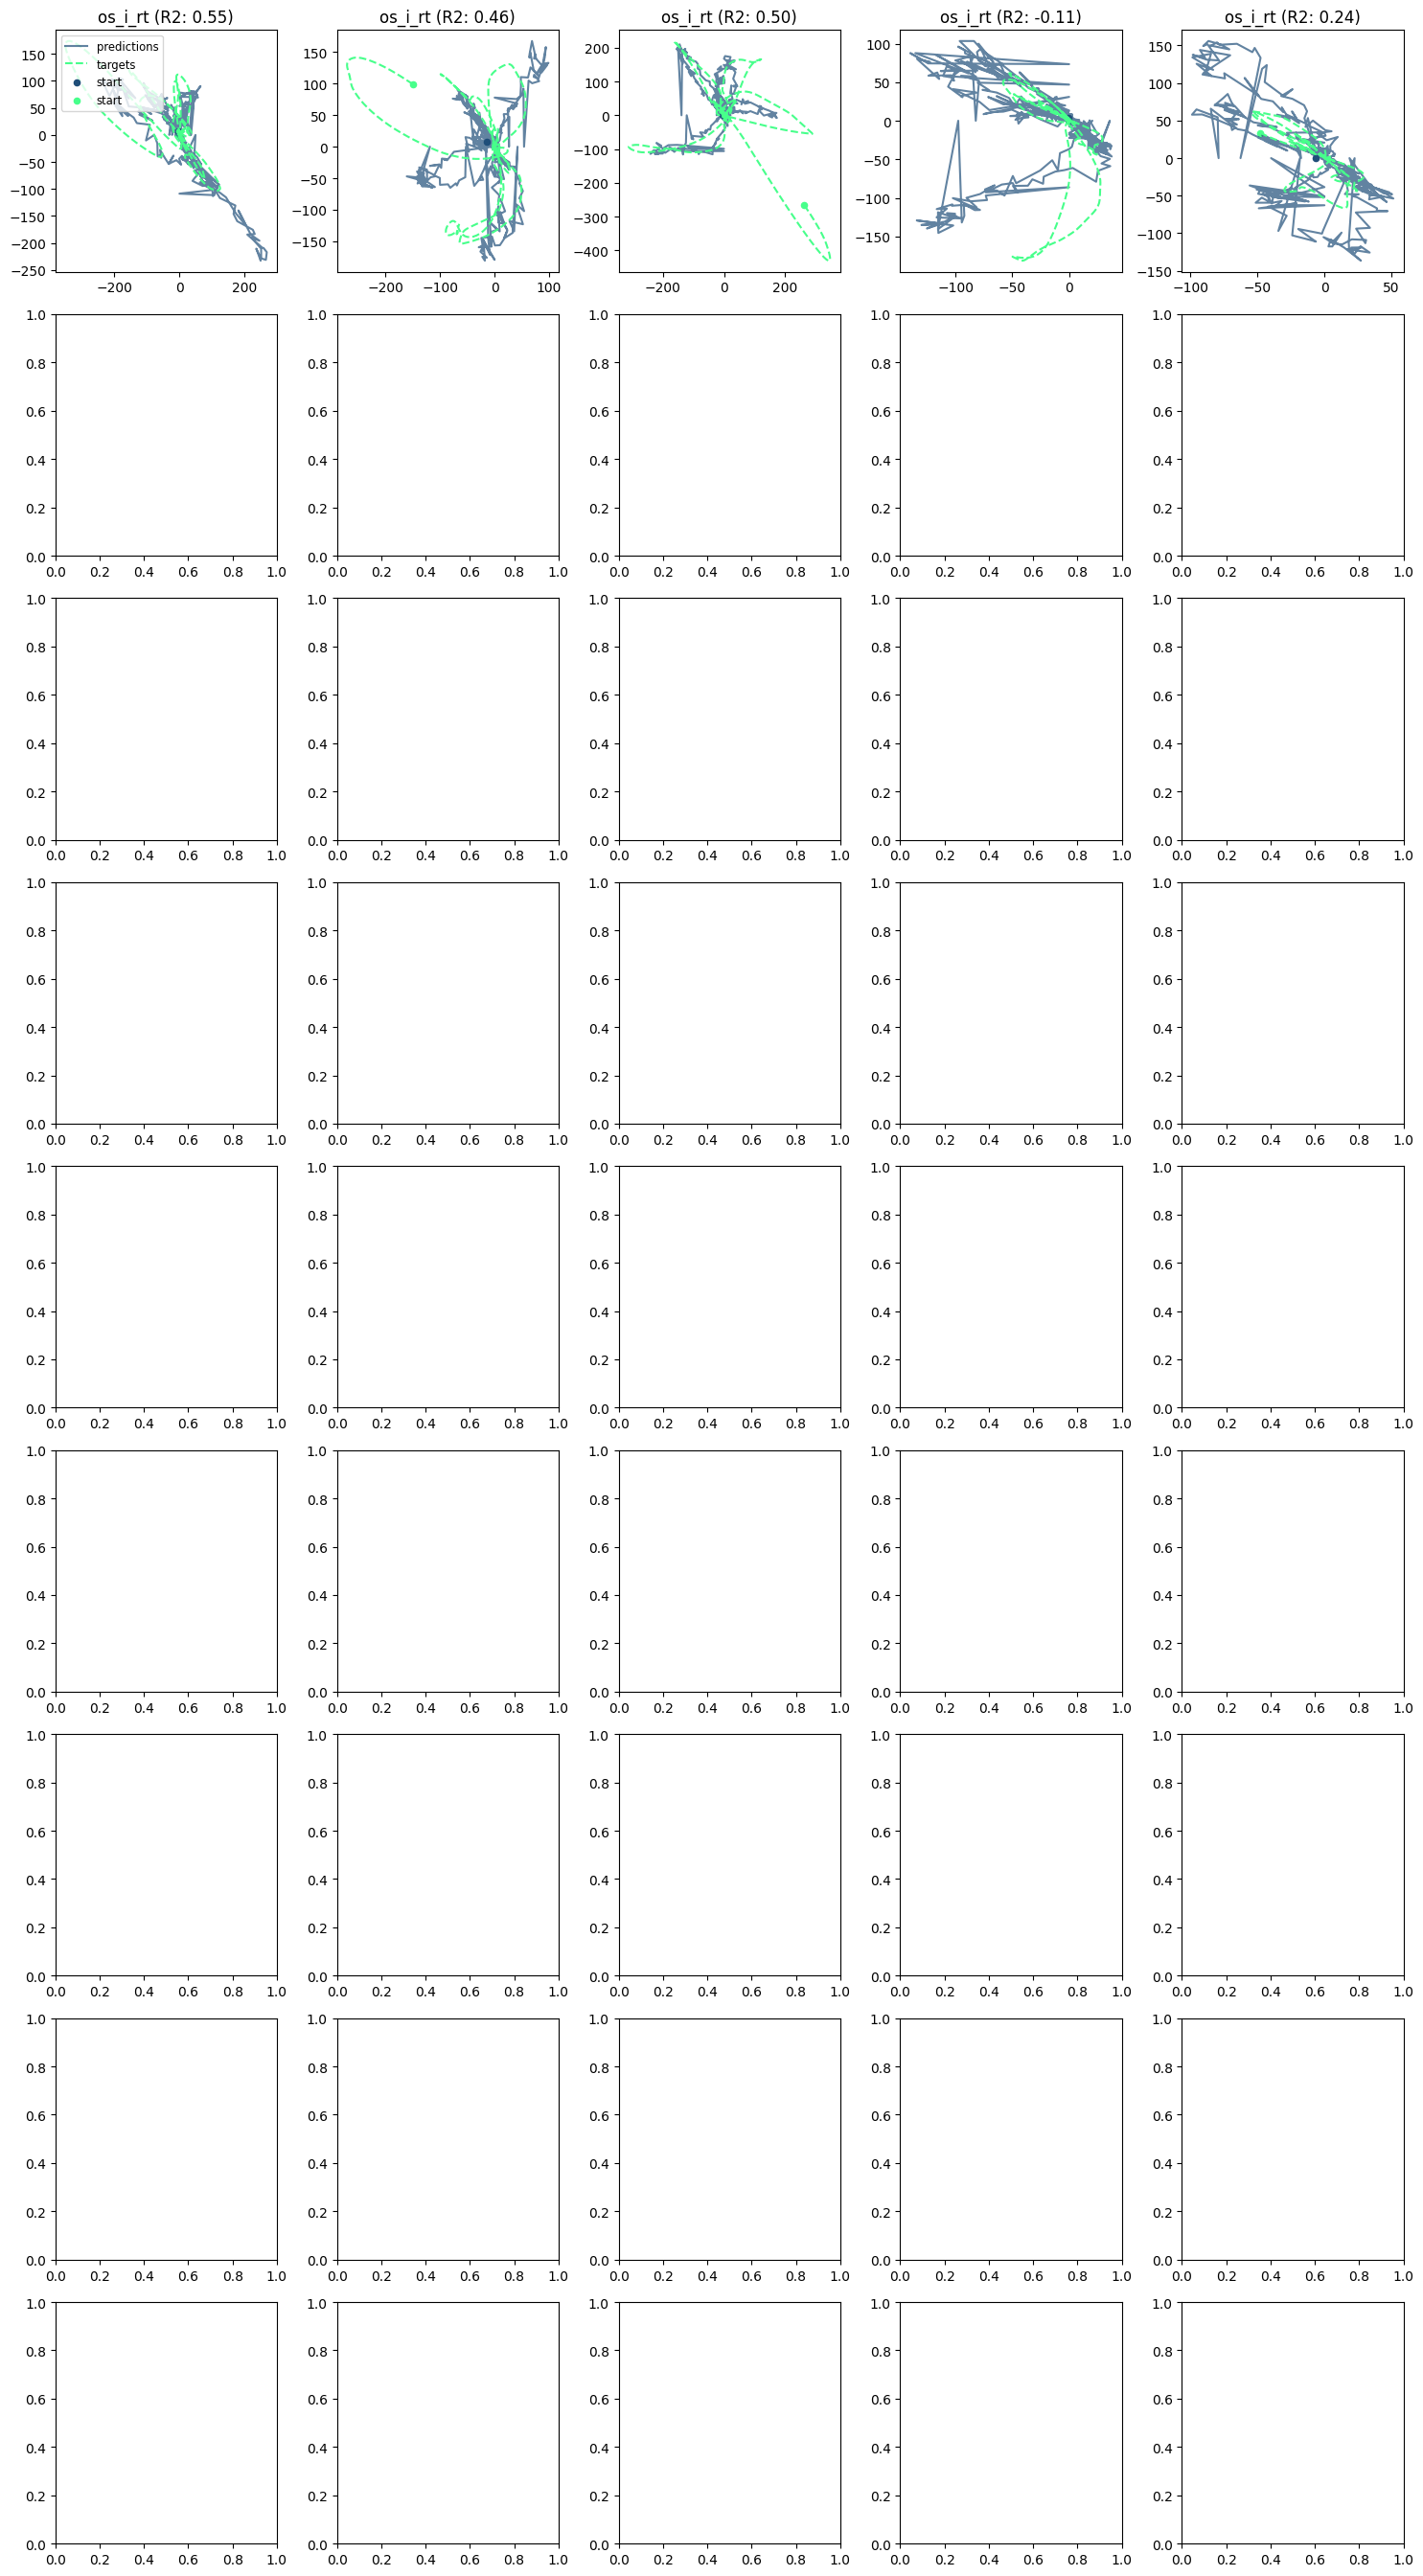

In [36]:
import matplotlib.pyplot as plt
r2_df_pos = r2_df
r2_df_pos['rank'] = r2_df_pos.groupby('dataset_group')['r2'].rank(ascending=True, method='first')
df_to_plot = r2_df_pos[(r2_df_pos['rank'] <= 5)].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 5, figsize=(15, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")
    
    
axs[0].legend(loc='upper left', fontsize='small')
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
r2_df['rank'] = r2_df.groupby('dataset_group')['r2'].rank(ascending=False, method='first')
df_to_plot = r2_df[r2_df['rank'] <= 5].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 5, figsize=(15, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")

axs[0].legend(loc='upper left', fontsize='small')
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
r2_df['rank'] = r2_df.groupby('dataset_group')['r2'].rank(ascending=True, method='first')
df_to_plot = r2_df[(r2_df['rank'] >8) &  (r2_df['rank'] <12)].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 4, figsize=(12, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")
    
    
axs[i].legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')